## Import Library

---

In [61]:
from bs4 import BeautifulSoup
import urllib
import requests
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## Get Data

---

In [204]:
# # take year, return dataframe of player salary for that year
def player_salary(year):
    for page in range(1, 20):
        salary_url = f'http://www.espn.com/nba/salaries/_/year/{year}/page/{page}/seasontype/4'
        req = urllib.request.Request(salary_url , headers={'User-Agent': 'Mozilla/5.0'})
        content = urllib.request.urlopen(req).read()
        table = pd.read_html(content)[0]
        if page == 1:
            df = table.copy()
        else:
            df = pd.concat([df, table], axis = 0)
    
    # set df columns and drop index
    salary_cols = df.iloc[0,:].values
    df.columns = salary_cols
    df = df.loc[df['RK'] != 'RK']
    df.reset_index(drop = True, inplace = True)
    
    return df

In [2]:
# # third-party website
# def player_per_game_data(year):
#     nba_url = f'https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html'
#     req = urllib.request.Request(nba_url , headers={'User-Agent': 'Mozilla/5.0'})
#     content = urllib.request.urlopen(req).read()
#     table = pd.read_html(content)
    
#     return table[0]

# payer_2019 = player_per_game_data(2019)
# payer_2019[0:25]    

In [35]:
# take year, return dataframe of players stats for that year
def nba_player_data(year):
    # get player data from nba website in json format
    headers = {
        'User-Agent': 'Mozilla/5.0',
        'Referer': 'https://stats.nba.com/players/drives/',
        'x-nba-stats-origin': 'stats',
        'x-nba-stats-token': 'true',
    }
    player_url = f'https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={year}&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=&Weight='
    req_url = requests.get(player_url, headers=headers)
    player_data = req_url.json()
    
    # get data by key: resultSets
    player_results = player_data['resultSets'][0]
    
    # get data feature names
    player_col_headers = player_results['headers']
    
    # get observations and set feature names
    player_results = json.dumps(player_results['rowSet'])
    df = pd.read_json(player_results)
    df.columns = player_col_headers
    df['season'] = year
    
    return df

In [6]:
# take year, return dataframe of teams stats for that year
def nba_team_data(year):
    # get team data from nba website in json format
    headers = {
        'User-Agent': 'Mozilla/5.0',
        'Referer': 'https://stats.nba.com/players/drives/',
        'x-nba-stats-origin': 'stats',
        'x-nba-stats-token': 'true',
    }
    team_url = f'https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={year}&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision='
    req_url = requests.get(team_url, headers=headers)
    team_data = req_url.json()
    
    # get data by key: resultSets
    team_results = team_data['resultSets'][0]
    
    # get data feature names
    team_col_headers = team_results['headers']
    
    # get observations and set feature names
    team_results = json.dumps(team_results['rowSet'])
    df = pd.read_json(team_results)
    df.columns = team_col_headers
    df['season'] = year
    
    return df

In [213]:
# get player data from 1996 to 2020
player_df = nba_player_data('1996-97')
for year in range(1997, 2020):
    temp_df =  nba_player_data(str(year) + '-' + str(year + 1)[-2:])
    player_df = pd.concat([player_df, temp_df], axis = 0)

# drop null values and reset index
player_df.dropna(axis = 0, inplace = True)
player_df.reset_index(inplace = True)

###### Avg Player Age vs Season|

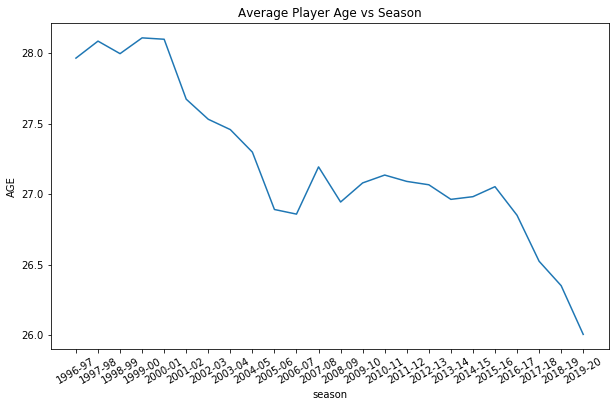

In [66]:
player_seasonAvg = player_df.groupby('season').mean()

fig, ax = plt.subplots(figsize = (10, 6), facecolor='w')
g = sns.lineplot(player_seasonAvg.index, player_seasonAvg['AGE'])
_ = g.set_title('Average Player Age vs Season')
_ = g.set_xticklabels(player_seasonAvg.index, rotation=30)

In [102]:
player_df['name_season'] = player_df['PLAYER_NAME'] + '_' + player_df['season']

In [107]:
player_df['PTS_PER_MIN'] = player_df['PTS']/player_df['MIN']
player_df_pts = player_df.sort_values(by='PTS_PER_MIN')

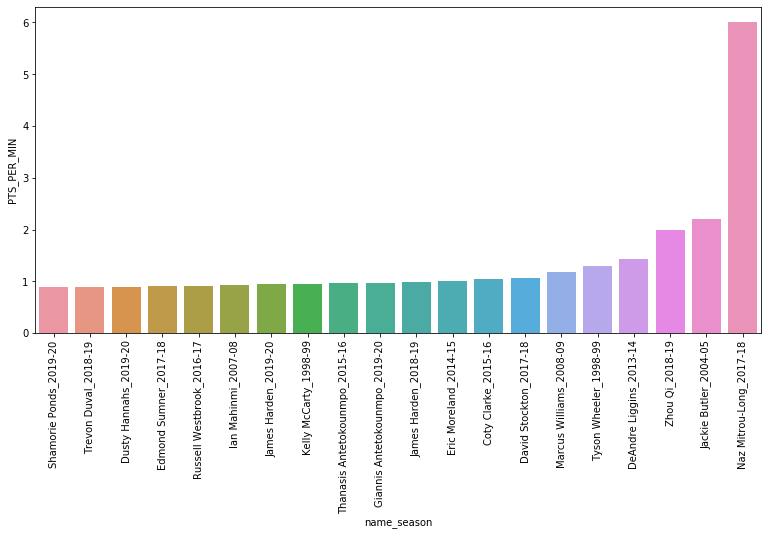

In [108]:
fig, ax = plt.subplots(figsize = (13, 6), facecolor='w')
g = sns.barplot(player_df_pts['name_season'][-20:], player_df_pts['PTS_PER_MIN'][-20:])
_ = g.set_title('Top 20 Players by Points per Minute')
_ = g.set_xticklabels(player_df_pts['name_season'][-20:], rotation = 90)

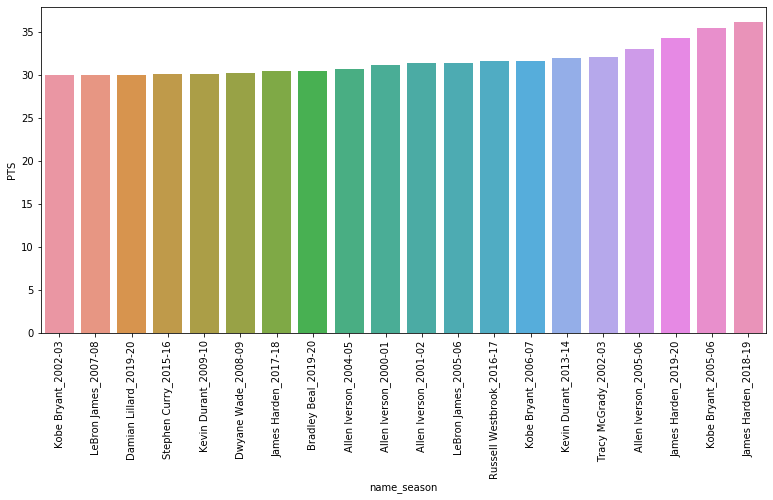

In [106]:
player_df_pts = player_df.sort_values(by='PTS')

fig, ax = plt.subplots(figsize = (13, 6), facecolor='w')
g = sns.barplot(player_df_pts['name_season'][-20:], player_df_pts['PTS'][-20:])
_ = g.set_title('Top 20 Players by Points')
_ = g.set_xticklabels(player_df_pts['name_season'][-20:], rotation = 90)

In [111]:
# select James Harden, Kobe Bryant and Allen Iverson
player_df_top3 = player_df.loc[(player_df['PLAYER_NAME'] == 'James Harden')
                               | (player_df['PLAYER_NAME'] == 'Kobe Bryant')
                               | (player_df['PLAYER_NAME'] == 'Allen Iverson')]

In [114]:
player_df_top3 = player_df_top3.sort_values(by='name_season')

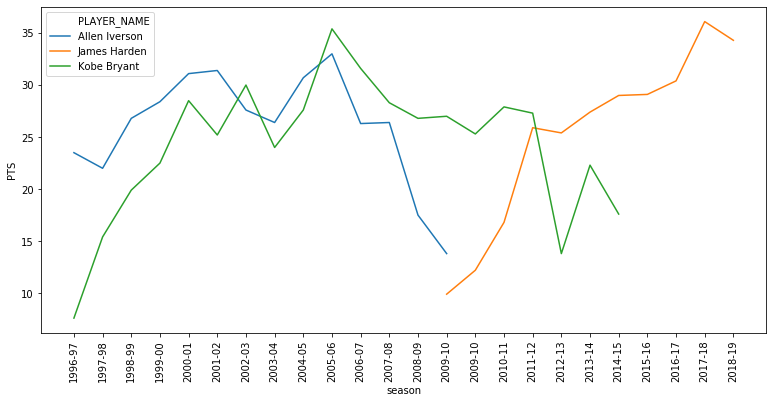

In [124]:
fig, ax = plt.subplots(figsize = (13, 6), facecolor='w')
g = sns.lineplot(player_df_top3['season'], player_df_top3['PTS'], 
                    hue = player_df_top3['PLAYER_NAME'])
_ = g.set_xticklabels(player_df_top3['season'], rotation = 90)

In [212]:
salary_df = player_salary(2020)
salary_df['NAME'] = salary_df['NAME'].apply(lambda x: x.split(',')[0])

In [217]:
salary_df = salary_df.rename(columns={'NAME': 'PLAYER_NAME'})

In [236]:
player_df_2020 = player_df.loc[player_df['season'] == '2019-20']

In [240]:
player_df_2020 = player_df_2020.merge(salary_df, on = 'PLAYER_NAME', how = 'left')

In [246]:
player_df_2020.dropna(axis = 0, inplace = True)
player_df_2020.reset_index(inplace = True)

In [254]:
X_train = player_df_2020[['PTS', 'AGE', 'GP', 'MIN', 'W', 'L', 'FGM', 'FGA', 
               'FG_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 
               'BLK', 'BLKA', 'PF']]
y_train = player_df_2020['SALARY'].replace('[\$,]', '', regex=True).astype(float)

In [255]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [300]:
import lightgbm
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators = 50, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=0)

In [301]:
pred = regr.predict(X_test)

In [302]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_test, pred)

32448766256409.0

In [304]:
mean_absolute_error(y_test, pred)

3919205.534962963

In [305]:
pred = regr.predict(X_train)
mean_squared_error(y_train, pred)

4368081618612.5205

In [306]:
mean_absolute_error(y_train, pred)

1401954.028888889

In [7]:
team_df = nba_team_data('2019-20')

In [8]:
team_df.head()

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS
0,1610612737,Atlanta Hawks,67,20,47,0.299,48.6,40.6,90.6,0.449,...,28,13,12,30,30,13,17,29,10,Atlanta Hawks
1,1610612738,Boston Celtics,72,48,24,0.667,48.4,41.3,89.6,0.461,...,8,6,5,25,20,15,9,3,10,Boston Celtics
2,1610612751,Brooklyn Nets,72,35,37,0.486,48.6,40.4,90.3,0.448,...,24,27,23,21,16,10,16,15,10,Brooklyn Nets
3,1610612766,Charlotte Hornets,65,23,42,0.354,48.5,37.3,85.9,0.434,...,14,26,25,20,3,16,30,27,10,Charlotte Hornets
4,1610612741,Chicago Bulls,65,22,43,0.338,48.2,39.6,88.6,0.447,...,27,1,26,28,24,29,27,22,10,Chicago Bulls


In [9]:
# get team name and abbrecivation dataframe
team_name_url = 'https://en.wikipedia.org/wiki/Wikipedia:WikiProject_National_Basketball_Association/National_Basketball_Association_team_abbreviations'
team_name = pd.read_html(team_name_url)
team_name = team_name[0][1:]
team_name.columns = ['TEAM_ABBREVIATION', 'TEAM_NAME']

In [10]:
# add team name feature to player_df
player_df = player_df.merge(team_name, on = 'TEAM_ABBREVIATION', how = 'left')

# select TEAM_NAME and W_PCT from team_df
team_df_wPCT = team_df[['TEAM_NAME', 'W_PCT']]

# team_df_wPCT left join player_df
player_df['TEAM_NAME'] = player_df['TEAM_NAME'].replace(['Los Angeles Clippers'], 'LA Clippers')
df = team_df_wPCT.merge(player_df, on = 'TEAM_NAME', how = 'left')

In [12]:
# train = df.groupby('TEAM_NAME').mean()
# train.reset_index(level=0, inplace=True)

In [17]:
from sklearn.cluster import KMeans
X = player_df[['AGE', 'GP', 'MIN', 'W', 'L', 'PTS', 'FGM', 'FGA', 
               'FG_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 
               'BLK', 'BLKA', 'PF']]
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(X)

In [18]:
labels = pd.DataFrame({'label': kmeans.labels_})

In [19]:
player_df = pd.concat([player_df, labels], axis = 1)

In [20]:
df = team_df_wPCT.merge(player_df, on = 'TEAM_NAME', how = 'left')

In [21]:
a = df.groupby('TEAM_NAME').mean()

In [22]:
a = a[['W_PCT_x', 'label']]

In [23]:
a.corr()

,W_PCT_x,label
W_PCT_x,1.000000,-0.369488
label,-0.369488,1.000000
